# Demo Whitespace RFExtractionAI

In this notebook we will see how to use the Konfuzio SDK to to train a model to find and extract relevant information like Name, Date and Recipient from payslip documents. 

Here we will see how to use the basic Konfuzio information extraction pipeline.

## Setting things up

First, we need to install the konfuzio_sdk package. See [here](https://github.com/konfuzio-ai/konfuzio-sdk) for more info.

In [ ]:
!pip install konfuzio-sdk

If you are using an online Project, you will also need to initialize the SDK and input your credentials. You can leave this commented out for now.

In [2]:
# !konfuzio_sdk init

In this demo, we will just download a Project folder from the Konfuzio repository that we use for testing:

In [3]:
!git init
!git remote add origin https://github.com/konfuzio-ai/konfuzio-sdk/
!git config core.sparseCheckout true
!echo "tests/example_project_data" > .git/info/sparse-checkout 
!echo "tests/variables.py" >> .git/info/sparse-checkout
!echo "tests/__init__.py" >> .git/info/sparse-checkout
!git pull origin master

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 8022, done.
remote: Counting objects: 100% (414/414), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 8022 (delta 293), reused 275 (delta 190), pack-reused 7608
Receiving objects: 100% (8022/8022), 23.87 MiB | 25.57 MiB/s, done.
Resolving deltas: 100% (5616/5616), done.
From https://github.com/konfuzio-ai/konfuzio-sdk
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


We also need to import the required packages. If you get a `ContextualVersionConflict` for the `tabulate` package, just restart the Colab runtime and run the next cell again. 

In [4]:
import os
import sys

import konfuzio_sdk
from konfuzio_sdk.data import Project
from konfuzio_sdk.trainer.information_extraction import RFExtractionAI
from konfuzio_sdk.tokenizer.regex import WhitespaceTokenizer
from konfuzio_sdk.api import upload_ai_model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: This module is WIP: https://gitlab.com/konfuzio/objectives/-/issues/9311
  


## Initializing the project and the training pipeline

Now we can load the Konfuzio project. Here we use a simple offline project included in the tests for the Konfuzio SDK. We can find it in the `OFFLINE_PROJECT` folder.

In [5]:
from tests.variables import OFFLINE_PROJECT, TEST_DOCUMENT_ID

We now can initialize the project. Since we're working with a local project, we don't need to specify a project `id_`. If you're working with a Project that can be found on the Konfuzio platform, you can just specify the `id_` of the Project and then start working with it in your local setup. 

In [6]:
project = Project(id_=None, project_folder=OFFLINE_PROJECT)

Each project has one or more categories which will tell us how to process the documents belonging to that category. Here we only have one category: `Lohnabrechnung` (i.e. payslip).

In [7]:
project.categories

[Lohnabrechnung (63), Quittung (GERMAN) (735)]

In [8]:
category = project.get_category_by_id(63)

Now we can initialize the training pipeline. Here we use the `RFExtractionAI` class.

The model is composed of a Label and LabelSet classifier both using a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from scikit-learn. Our approach is inspired by [Sun et al. (2021)](https://arxiv.org/abs/2103.14470)

We first split the text of the Document into smaller chunks of text based on whitespaces and then use a combination of features to train the first Label classifier to assign labels to these chunks of text.

After the Label classifier, the LabelSet classifier takes the predictions from the Label classifier as input. The LabelSet classifier groups Annotations into Annotation sets.

Here we set `use_separate_labels` to True. It can be help with the training of the LabelSet classifier when there are labels that can be contained in more than one LabelSet.

In [9]:
pipeline = RFExtractionAI(use_separate_labels=True)
pipeline.category = category

We can also set the pipeline `test_documents` attribute. This will be used to evaluate our model later on. In this project we have 3 test documents.

In [10]:
pipeline.test_documents = category.test_documents()
pipeline.test_documents

[Document Auswertungspaket - unterschiedliche B_N-Auswertungen.pdf_18.pdf (44865),
 Document Auswertungspaket - unterschiedliche B_N-Auswertungen.pdf_17.pdf (44866),
 Document Auswertungspaket - unterschiedliche B_N-Auswertungen.pdf_19.pdf (44867)]

Now it's time to look at our training documents.

In [11]:
# getting all the documents in category 63
documents = category.documents()

We have 25 training documents we can use to train our classifier. 

In [12]:
len(documents)

25

Let's have a look at what exactly a document in this dataset looks like. 

In [13]:
document = documents[0]

In [14]:
document.text

"                                                            x02   328927/10103/00104\nAbrechnung  der Brutto/Netto-Bezüge   für Dezember 2018                   22.05.2018 Bat:  1\n \nPersonal-Nr.  Geburtsdatum ski Faktor  Ki,Frbtr.Konfession  ‚Freibetragjährl.! |Freibetrag mt! |DBA  iGleitzone  'St.-Tg.  VJuUr. üb. |Url. Anspr. Url.Tg.gen.  |Resturlaub\n00104 150356 1  |     ‚ev                              30     400  3000       3400\n \nSV-Nummer       |Krankenkasse                       KK%®|PGRS Bars  jum.SV-Tg. Anw. Tage |UrlaubTage Krankh. Tg. Fehlz. Tage\n                                             \n50150356B581 AOK  Bayern Die Gesundheitskas 157 101 1111 1 30\n \n                                             Eintritt   ‚Austritt     Anw.Std.  Urlaub Std.  |Krankh. Std. |Fehlz. Std.\n                                             \n                                             170299  L L       l     L     l     l\n -                                       +  Steuer-ID       IMrB?

This is the output of Optical Character Recognition (OCR) model on the following image:

[Page 0 in Document Gehalt.pdf (44823)]


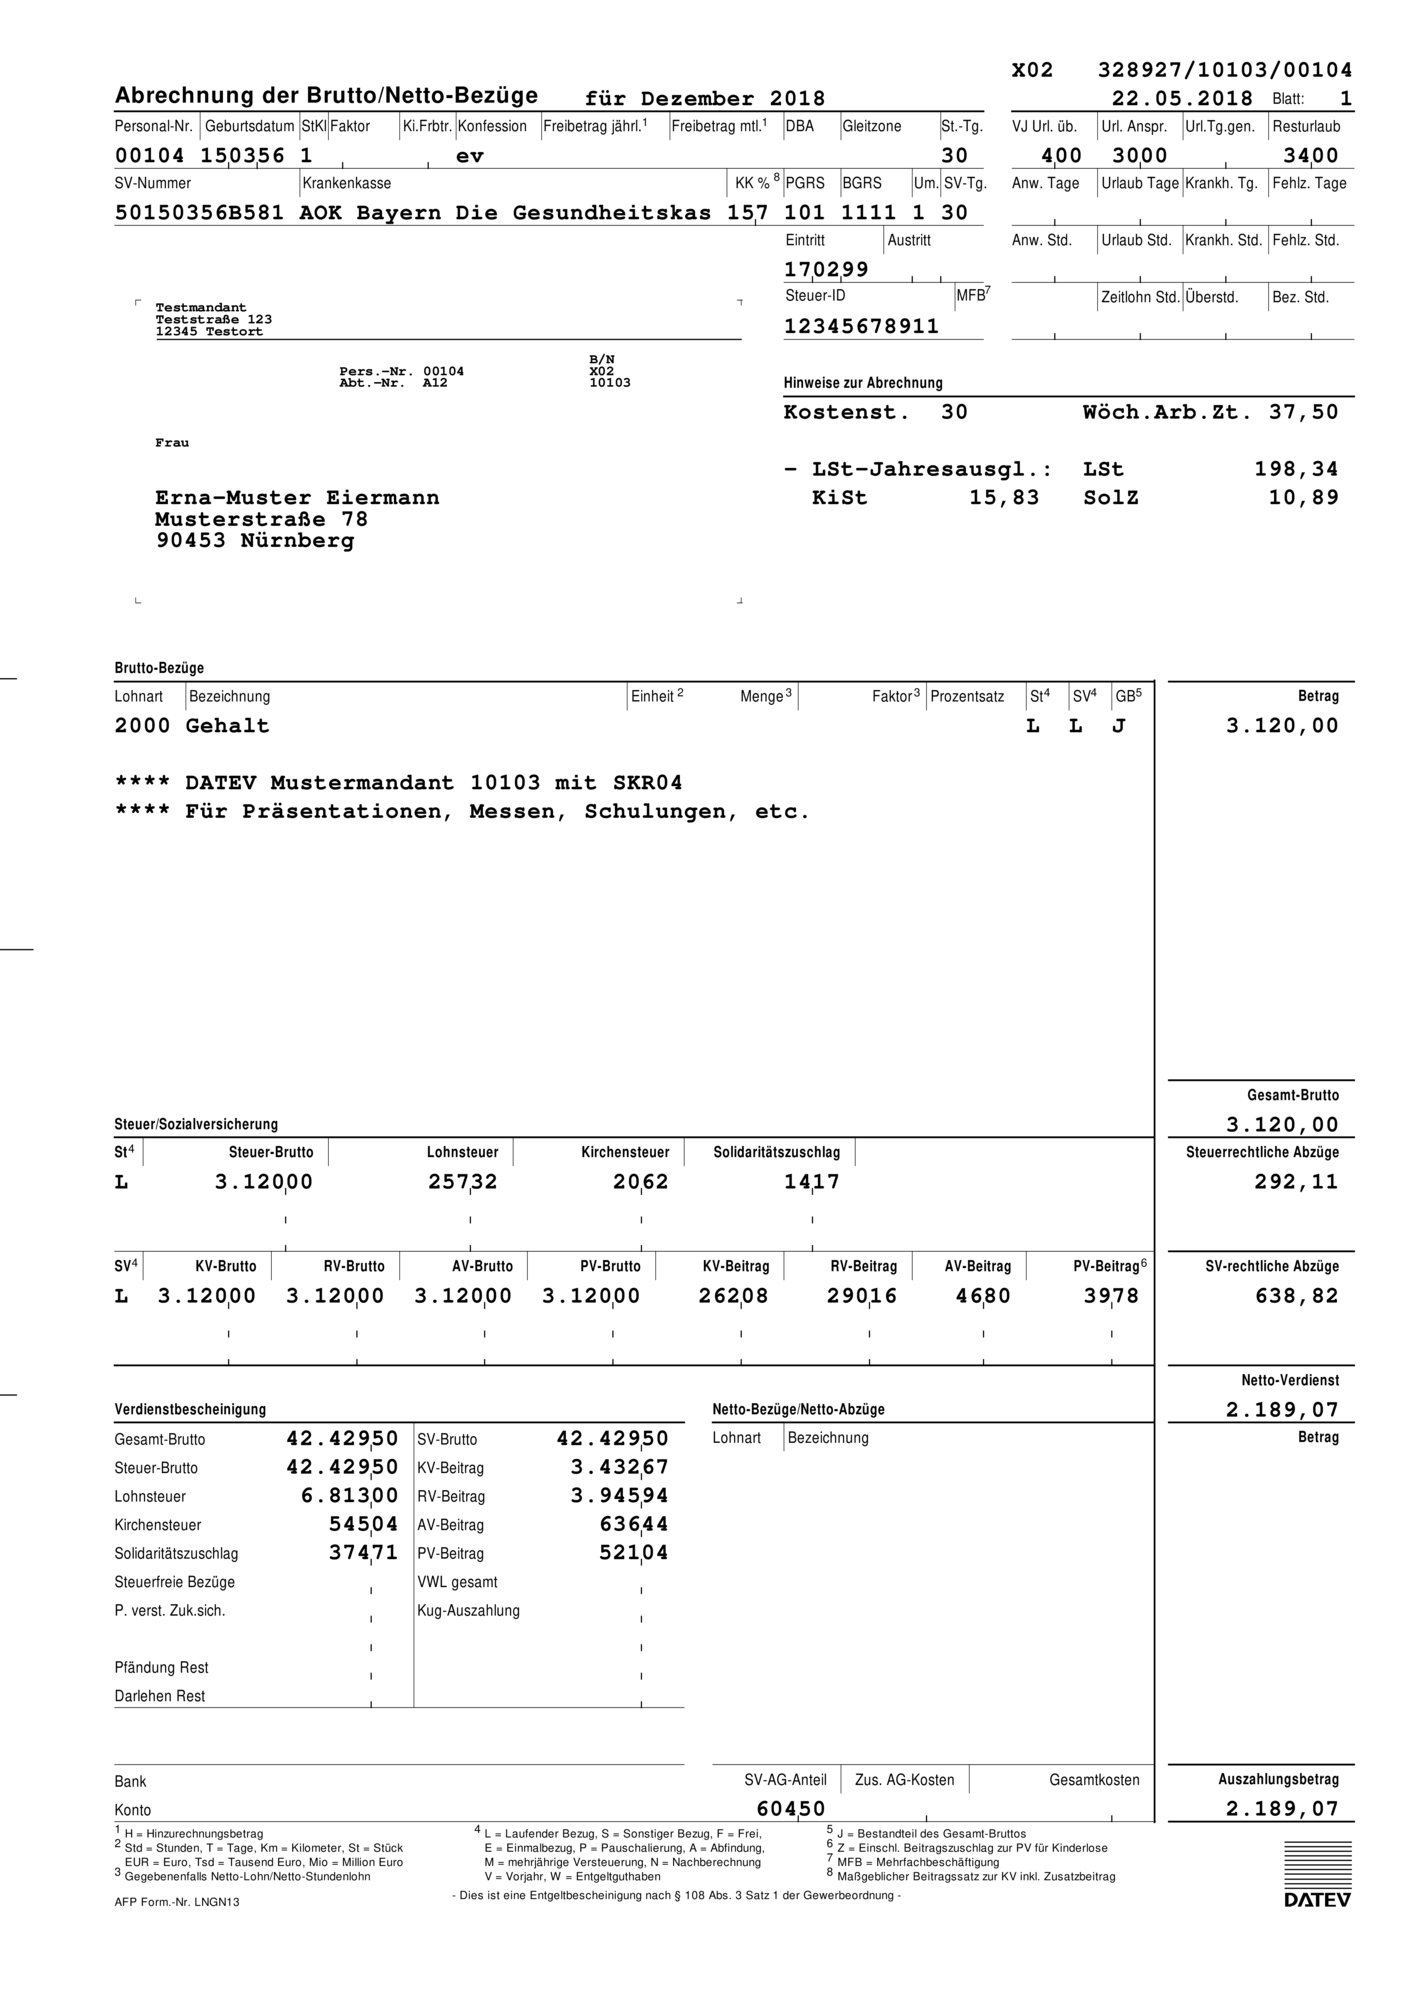

In [15]:
print(document.pages())
document.get_page_by_index(0).get_image()

And those are the annotations we want to find:

In [16]:
document.annotations()

[Annotation (https://app.konfuzio.com/a/12516017) Austellungsdatum (66, 78), (159, 169),
 Annotation (https://app.konfuzio.com/a/9585450) Personalausweis (352, 357),
 Annotation (https://app.konfuzio.com/a/4420022) Steuerklasse (365, 366),
 Annotation (https://app.konfuzio.com/a/9609649) Personalausweis (1194, 1199),
 Annotation (https://app.konfuzio.com/a/9812334) Gesamt-Brutto (1498, 1504), (1582, 1587),
 Annotation (https://app.konfuzio.com/a/4420057) Vorname (1507, 1518),
 Annotation (https://app.konfuzio.com/a/4420245) Nachname (1519, 1527),
 Annotation (https://app.konfuzio.com/a/4420346) Lohnart (1758, 1762),
 Annotation (https://app.konfuzio.com/a/4420348) Bezeichnung (1763, 1769),
 Annotation (https://app.konfuzio.com/a/11613686) Betrag (1831, 1839),
 Annotation (https://app.konfuzio.com/a/4420363) Gesamt-Brutto (2111, 2119),
 Annotation (https://app.konfuzio.com/a/9585509) Sozialversicherung (2255, 2262),
 Annotation (https://app.konfuzio.com/a/9585548) Sozialversicherung (22

Documents in this category may include the following fields:

In [17]:
for label in category.labels:
    print(label.name)

Menge
Steuer-Brutto
Bezeichnung
Sozialversicherung
Betrag
Personalausweis
Netto-Verdienst
Bank inkl. IBAN
Faktor
Lohnart
Nachname
Steuerrechtliche Abzüge
NO_LABEL
EMPTY_LABEL
Auszahlungsbetrag
Austellungsdatum
Vorname
Gesamt-Brutto
Steuerklasse


This is all the information we may want to identify in documents of this category.

## Set the Whitespace Tokenizer

Now we need to decide how we will segment our text for entity detection and classification. In this example we will use a simple [Whitespace tokenizer](https://dev.konfuzio.com/sdk/sourcecode.html#konfuzio_sdk.tokenizer.regex.WhitespaceTokenizer). It will seperate text segments by whitespace and allow us to label each individual segment. 

In [18]:
pipeline.tokenizer = WhitespaceTokenizer()

In [19]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

To train our label classifier, we first need to extract all the features for each segment of text, which will allow the classifier to automatically detect where the relevant information is. These include features about the text in a segment, its position on the page and its relation with and features about nearby segments of text.

In [20]:
%%capture
# Extract features
pipeline.df_train, pipeline.label_feature_list = pipeline.feature_function(documents=documents, require_revised_annotations=False)

ERROR:konfuzio_sdk.trainer.information_extraction:Annotation (https://app.konfuzio.com/a/9760937) Auszahlungsbetrag (236, 237) is unrevised in this dataset and may impact model performance! Please revise it manually by either confirming it, rejecting it, or modifying it.
ERROR:konfuzio_sdk.trainer.information_extraction:Annotation (https://app.konfuzio.com/a/9647432) Auszahlungsbetrag (2619, 2624) is unrevised in this dataset and may impact model performance! Please revise it manually by either confirming it, rejecting it, or modifying it.


In [21]:
pipeline.df_train.shape

(7825, 359)

{{ len(pipeline.label_feature_list) }} is the number of features we use to classify each annotation.

In [22]:
len(pipeline.label_feature_list)

270

Now we're ready to do train our classifier:

In [23]:
# Start to train the Classifier.
pipeline.fit()

RandomForestClassifier(class_weight='balanced', max_depth=100, random_state=420)

## Evaluation
And now we can evaluate our classifier like this.

In [24]:
%%capture
evaluation = pipeline.evaluate_full()

This will return an Evaluation object with all the relevant evaluation stats like the [F1-score](https://en.wikipedia.org/wiki/F-score):

In [25]:
print('F1', evaluation.f1(None))
print('tp', evaluation.tp(None))
print('fp', evaluation.fp(None))
print('fn', evaluation.fn(None))
print('tn', evaluation.tn(None))

F1 0.9739130434782609
tp 112
fp 6
fn 0
tn 807


### Display

We can also show the output of the model for visual inspection.

In [26]:
%%capture
test_document = project.get_document_by_id(TEST_DOCUMENT_ID)

virtual_doc = pipeline.extract(test_document)

Now we can see what the model has learned:

/usr/local/lib/python3.7/dist-packages/konfuzio_sdk/data.py:162: FutureWarning: WIP: Modifications before the next stable release expected.
  scale_mult * ann.spans[0].bbox().x0,
/usr/local/lib/python3.7/dist-packages/konfuzio_sdk/data.py:1049: FutureWarning: WIP: Modifications before the next stable release expected.
  characters = {key: document.bboxes.get(key) for key in character_range if document.text[key] != ' '}


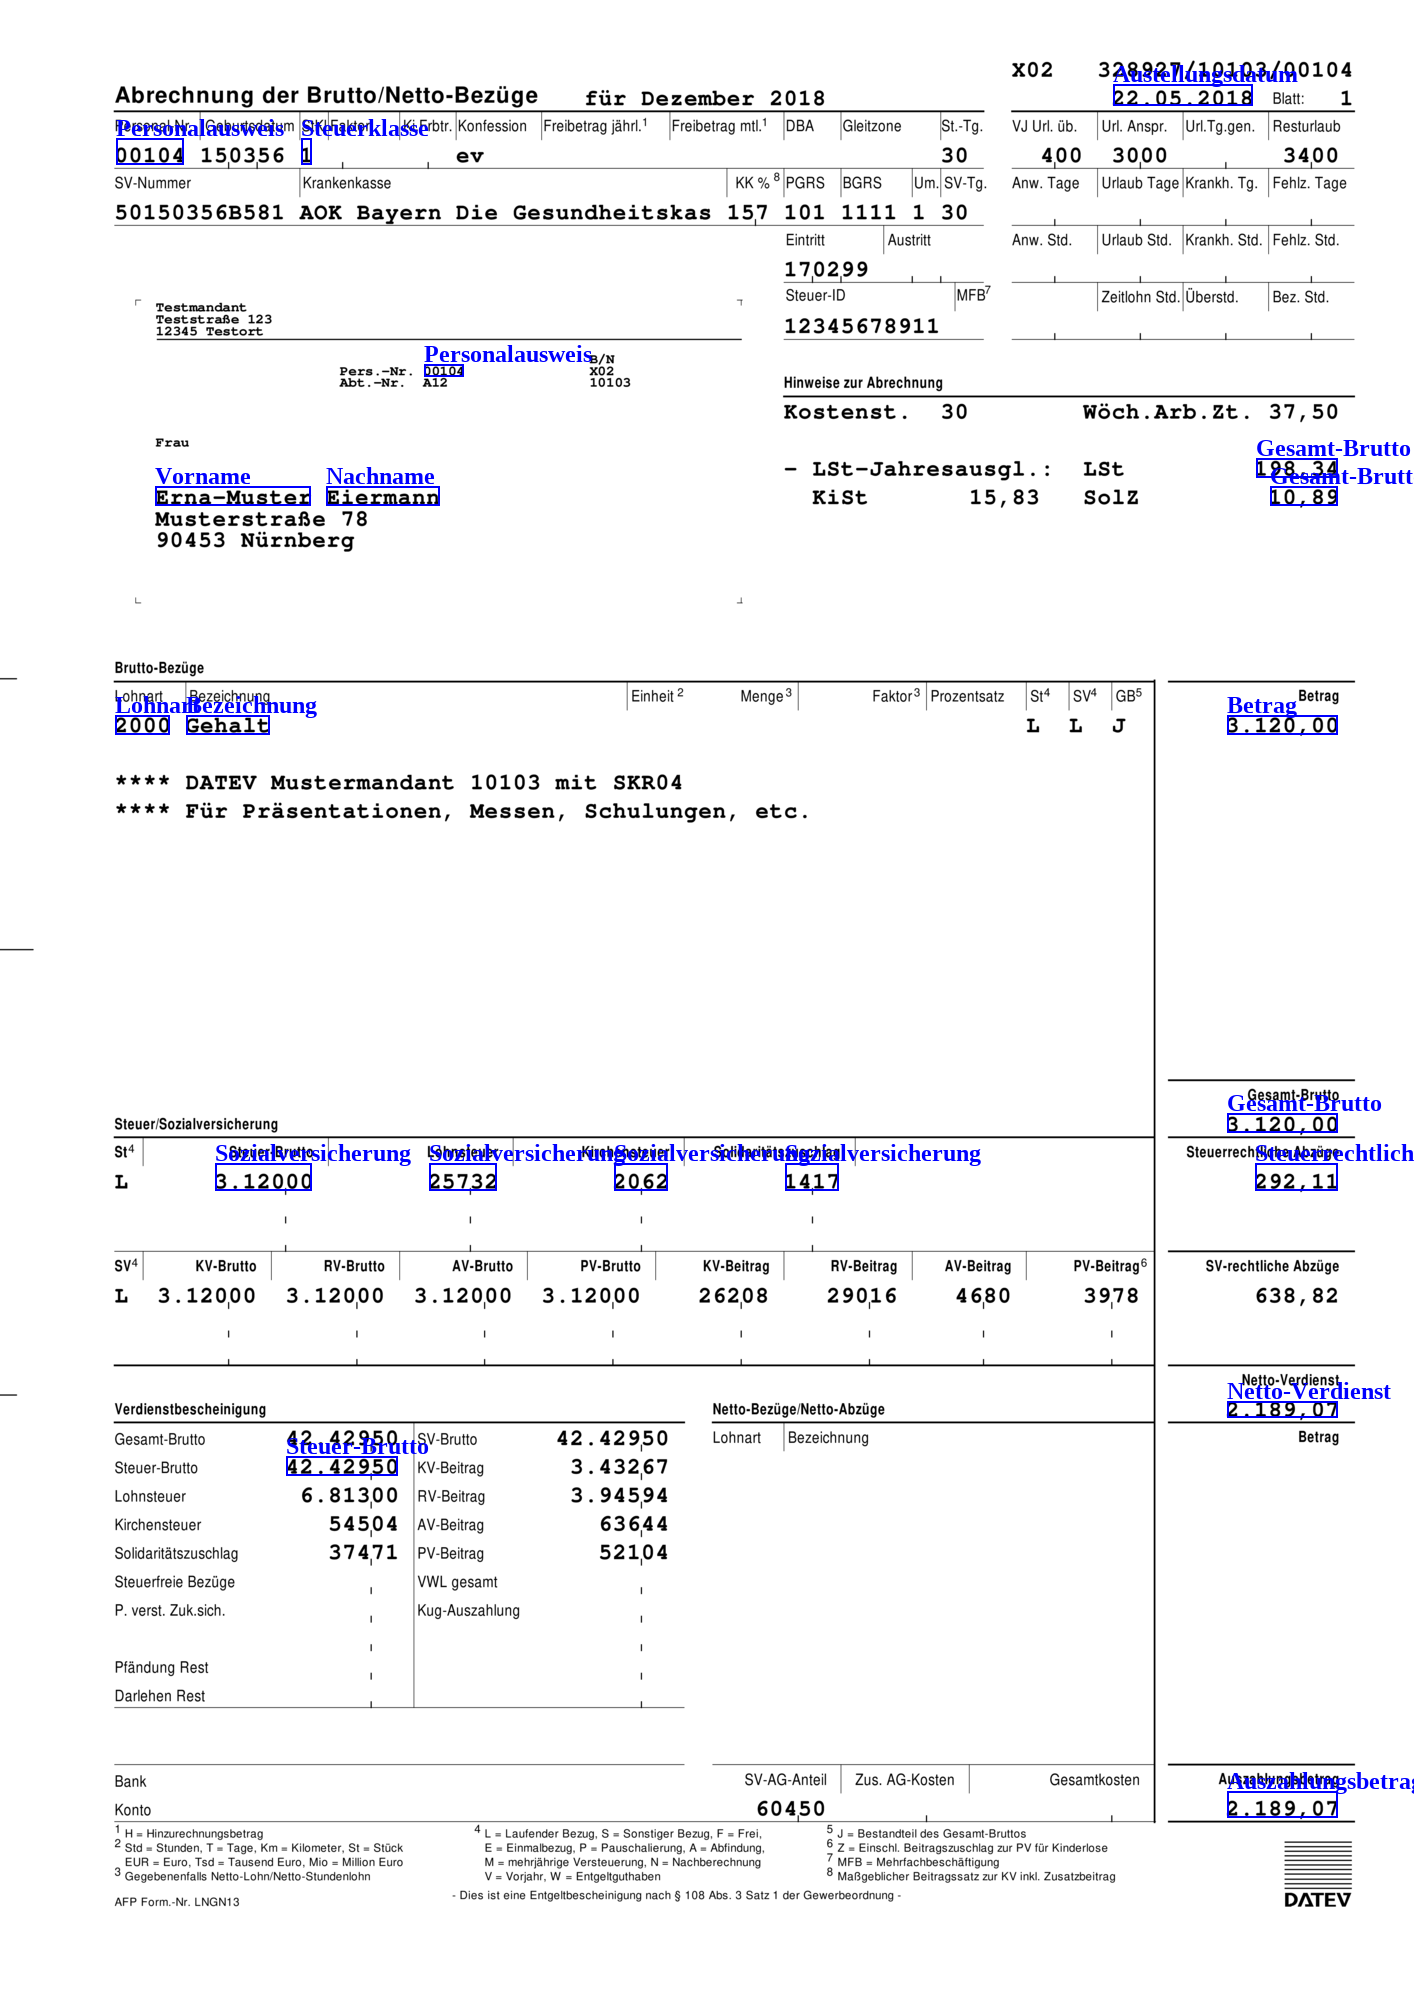

In [27]:
virtual_doc.get_page_by_index(0).get_annotations_image()

You may also upload the model to the Konfuzio platform and view extraction results with the Konfuzio SmartView.

And now we can save the trained model:

In [28]:
pipeline_path = pipeline.save(output_dir=project.model_folder)
pipeline_path

'/content/tests/example_project_data/models/2022-11-04-12-08-52_lohnabrechnung.pkl'

You can only upload your Annotation classifier to your own instance of the Konfuzio Server. Please [contact](https://konfuzio.com/en/contact/) our sales if you want to install Konfuzio Server.

In [29]:
upload_ai_model(ai_model_path=pipeline_path)

PermissionError: ignored